# Load the data

In [37]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [38]:
import os
import numpy as np

# Path
folder1 = "/content/drive/MyDrive/Balloon_model/Data2/Group1"
folder2 = "/content/drive/MyDrive/Balloon_model/Data2/Group2"
# List of .npz files
files1 = [f for f in os.listdir(folder1) if f.startswith("90ROI") and f.endswith(".npz")] # data with 10 ROIs
files1.sort()

files2 = [f for f in os.listdir(folder2) if f.startswith("90ROI") and f.endswith(".npz")] # data with 10 ROIs
files2.sort()

# load all the files
data_list1 = []
for file in files1:
    path = os.path.join(folder1, file)
    with np.load(path, allow_pickle=True) as data:
        data_list1.append({k: data[k] for k in data.files})

print(f"{len(data_list1)} archivos cargados correctamente.")

data_list2 = []
for file in files2:
    path = os.path.join(folder2, file)
    with np.load(path, allow_pickle=True) as data:
        data_list2.append({k: data[k] for k in data.files})

print(f"{len(data_list2)} archivos cargados correctamente.")

200 archivos cargados correctamente.
200 archivos cargados correctamente.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from scipy.interpolate import interp1d
import sys
import seaborn as sns
from sklearn.preprocessing import normalize
module_name_bmn = "Dyn_BMN"
file_path_bmn = "/content/drive/MyDrive/Balloon_model/Dyn_BMN.py"
module_name_noise = "noise"
file_path_noise = "/content/drive/MyDrive/Balloon_model/noise.py"

#BalloonModelNet

def load_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module
#
dyn_bmn = load_module_from_path(module_name_bmn, file_path_bmn)
noise = load_module_from_path(module_name_noise, file_path_noise)

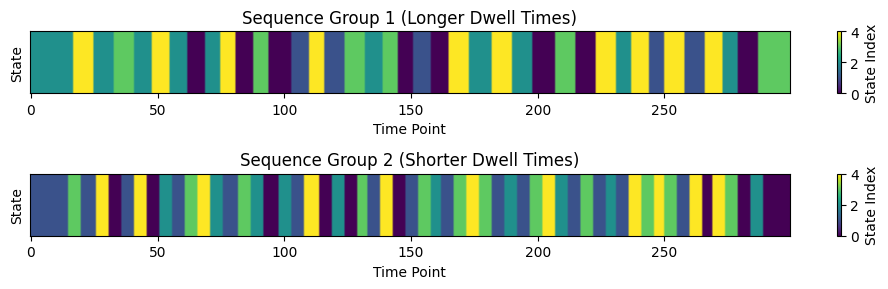

In [72]:
import matplotlib.pyplot as plt
import numpy as np

sample1 = data_list1[0]["sample"]
sample2 = data_list2[0]["sample"]

# Visualize sample1 and sample2 as color bars
fig, axes = plt.subplots(2, 1, figsize=(10, 3))

im_sample1 = axes[0].imshow(sample1.reshape(1, -1), aspect='auto', cmap='viridis')
axes[0].set_title('Sequence Group 1 (Longer Dwell Times)')
axes[0].set_xlabel('Time Point')
axes[0].set_ylabel('State')
axes[0].set_yticks([])
fig.colorbar(im_sample1, ax=axes[0], label='State Index')

im_sample2 = axes[1].imshow(sample2.reshape(1, -1), aspect='auto', cmap='viridis')
axes[1].set_title('Sequence Group 2 (Shorter Dwell Times)')
axes[1].set_xlabel('Time Point')
axes[1].set_ylabel('State')
axes[1].set_yticks([])
fig.colorbar(im_sample2, ax=axes[1], label='State Index')

plt.tight_layout()
plt.show()

In [41]:
data_list = data_list1 + data_list2 # combine the groups
#data_list = data_noisy
labels = np.array([0]*len(data_list1) + [1]*len(data_list2))  # 0 = group1, 1 = group2
data_bold = np.array([data['bold'][10:-5,:] for data in data_list])

#  (n_subjects, n_rois, time_points)
# data_bold = data_bold.transpose(0, 2, 1) para hmmlearn
#data_bold = data_bold.transpose(1,0,2)
print(data_bold.shape)

(400, 283, 90)


# GLHMM implementation

In [42]:
!pip install git+https://github.com/vidaurre/glhmm

  Cloning https://github.com/vidaurre/glhmm to /tmp/pip-req-build-_oy5cwv8
  Running command git clone --filter=blob:none --quiet https://github.com/vidaurre/glhmm /tmp/pip-req-build-_oy5cwv8
  Resolved https://github.com/vidaurre/glhmm to commit 57c2f7995eb5087f6e2e132c47a7dd692a55363d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [43]:
!pip install glhmm

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from glhmm import glhmm, preproc, utils, graphics

In [45]:
from glhmm.auxiliary import make_indices_from_T

n_subjects, n_timepoints, n_regions = data_bold.shape
X_concat = np.concatenate([data_bold[i] for i in range(n_subjects)], axis=0)
T = [n_timepoints]*n_subjects
index = make_indices_from_T(T)
print(X_concat.shape)
print(index[:5])

(113200, 90)
[[   0  283]
 [ 283  566]
 [ 566  849]
 [ 849 1132]
 [1132 1415]]


### Preprocessed
#### 1. Standardizes

Each time series is centered (the mean is subtracted) and scaled by its standard deviation. The GLHMM and HMM-MAR assume that covariances and means are on a comparable scale.

#### 2. Splits the data according to indexes

Splits the data according to those lengths

#### 3. Computes global statistics for the model (returned in log)
log contains: ROI-wise means, Variances, Initial covariances, Prior parameters for initializing the HMM, Useful information for fitting.




In [46]:
data,_,log = preproc.preprocess_data(X_concat, index)

### Training

In [47]:
hmm = glhmm.glhmm(model_beta='no', K=5, covtype='full', preproclogY=log)
print(hmm.hyperparameters)

{'K': 5, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True])}


In [48]:
# np.random.seed(123)
# hmm.train(X=None, Y=data, indices=index)

np.random.seed(123)
Gamma,Xi,FE = hmm.train(X=None, Y=data, indices=index)

GPU acceleration not selected, but cupy detected. Consider enabling GPU acceleration by setting the "gpu_acceleration" option to >=1.
Init repetition 1 free energy = -619314.6989908526
Init repetition 2 free energy = -545196.4726013804
Init repetition 3 free energy = -931165.2462774953
Init repetition 4 free energy = -1077425.5212269751
Init repetition 5 free energy = -974160.1267712124
Best repetition: 4
Cycle 1 free energy = -1129243.6117405666
Cycle 2 free energy = -1145688.4646643135
Cycle 3, free energy = -1149878.2541647395, relative change = 0.20304638259773305
Cycle 4, free energy = -1151345.3003559276, relative change = 0.06637710885893228
Cycle 5, free energy = -1151914.531866037, relative change = 0.025108443193268385
Cycle 6, free energy = -1152145.9379691912, relative change = 0.010104043617410083
Cycle 7, free energy = -1152244.4032288105, relative change = 0.004280950925954745
Cycle 8, free energy = -1152313.4257891274, relative change = 0.002991899291929594
Cycle 9, fre

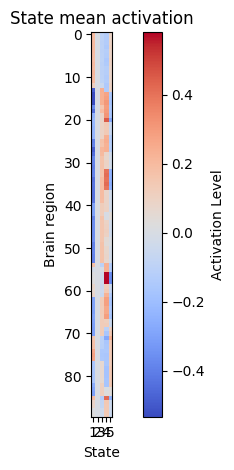

In [49]:
K = hmm.hyperparameters["K"] # the number of states
q = data.shape[1] # the number of parcels/channels
state_means = np.zeros(shape=(q, K))
state_means = hmm.get_means() # the state means in the shape (no. features, no. states)

cmap = "coolwarm"
plt.imshow(state_means, cmap=cmap,interpolation="none")
plt.colorbar(label='Activation Level') # Label for color bar
plt.title("State mean activation")
plt.xticks(np.arange(K), np.arange(1,K+1))
plt.gca().set_xlabel('State')
plt.gca().set_ylabel('Brain region')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Conectividad de estados

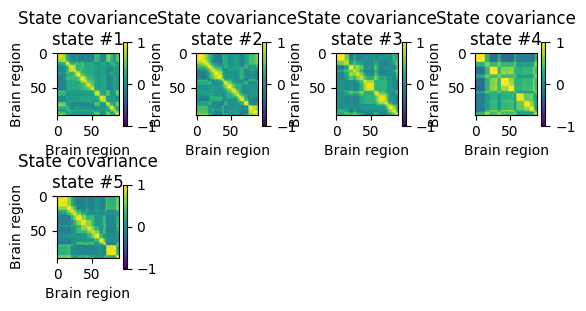

In [50]:
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = hmm.get_covariance_matrix(k=k) # the state covariance matrices in the shape (no. features, no. features, no. states)
for k in range(K):
    plt.subplot(3,4,k+1)
    plt.imshow(state_FC[:,:,k],cmap="viridis", vmin=-1,vmax=1)#cmap)
    plt.xlabel('Brain region')
    plt.ylabel('Brain region')
    plt.colorbar()
    plt.title("State covariance\nstate #%s" % (k+1))
plt.subplots_adjust(hspace=0.7, wspace=0.8)
plt.show()

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def concatenate_bold_by_state(bold_signal, states_array, state_index, shift):
    """
    extract the segments of BOLD signal of one state

    Parameters
    bold_signal : np.ndarray (N_pts, N_rois)
    states_array : np.ndarray (N_pts,) the states sequence
    state_index : int the index of the state to extract
    Returns
    concatenated_bold : np.ndarray (N_selected_pts, N_rois)
    """
    shifted_states = np.roll(states_array, shift)[:-2]


    # Find the indices where the state is the desired one
    indices_of_state = np.where(shifted_states == state_index)[0]
    #print(indices_of_state)

    # Select the corresponding rows from the bold signal
    concatenated_bold = bold_signal[indices_of_state, :]

    return concatenated_bold

def plot_fc_and_corr_matrices(FC_states, corr_matrices, region_labels=None):
    """
    Parameters
    FC_states : list of np.ndarray, original FC matrices
    corr_matrices : list of np.ndarray, calculated correlation matrices
    region_labels : list of str, optional labels for regions
    """
    n_states = len(FC_states)
    if len(corr_matrices) != n_states:
        print("Warning: Number of FC states and correlation matrices do not match.")
        return
    if region_labels is None:
        region_labels = [f"ROI{i}" for i in range(FC_states[0].shape[0])]
    fig, axes = plt.subplots(2, n_states, figsize=(4 * n_states, 8))

    for k in range(n_states):
        # Original FC matrix
        sns.heatmap(FC_states[k], ax=axes[0, k], cmap='coolwarm', cbar=True, vmin=-1,vmax=1,
                 #   xticklabels=region_labels, yticklabels=region_labels)
                 xticklabels=False, yticklabels=False)
        axes[0, k].set_title(f"Ground Truth State {k}")

        # Estimated Correlation matrix
        sns.heatmap(corr_matrices[k], ax=axes[1, k], vmin=-1, vmax=1, cmap='coolwarm',
                    #xticklabels=region_labels, yticklabels=region_labels)
                    xticklabels=False, yticklabels=False)
        axes[1, k].set_title(f"Estimated Correlation State {k}")

    axes[0, 0].set_ylabel("Ground Truth FC")
    axes[1, 0].set_ylabel("Estimated Correlation")

    plt.tight_layout()
    plt.show()

def corr_of_states(dataset, shift=2):
    """
    Parameters
    dataset:[dict()], list of dicts, each dict is a subject
    shift: int, number of time points to shift the states sequence
    Return
    corr_matrices : list of np.ndarray, correlation matrix for each state
    """

    FC_states = dataset[0]["FC_states"]
    n_states = len(FC_states)
    corr_matrices = []

    for state in range(n_states):
        concatenate_all_subj = []
        for i, subj in enumerate(dataset):
            state_seq = subj["sample"]
            bold = subj["bold"]
            #print(bold.shape)
            concatenated_bold_subject = concatenate_bold_by_state(bold, state_seq, state, shift)
            if concatenated_bold_subject.shape[0] > 0:
                concatenate_all_subj.append(concatenated_bold_subject)

        if len(concatenate_all_subj) > 0:
            concatenate_all_subj = np.concatenate(concatenate_all_subj, axis=0)
            corr_matrix = np.corrcoef(concatenate_all_subj.T)
            corr_matrices.append(corr_matrix)
        else:
            corr_matrices.append(np.zeros_like(FC_states[0])) # Append zero matrix if no data for state

    plot_fc_and_corr_matrices(FC_states, corr_matrices)
    return corr_matrices


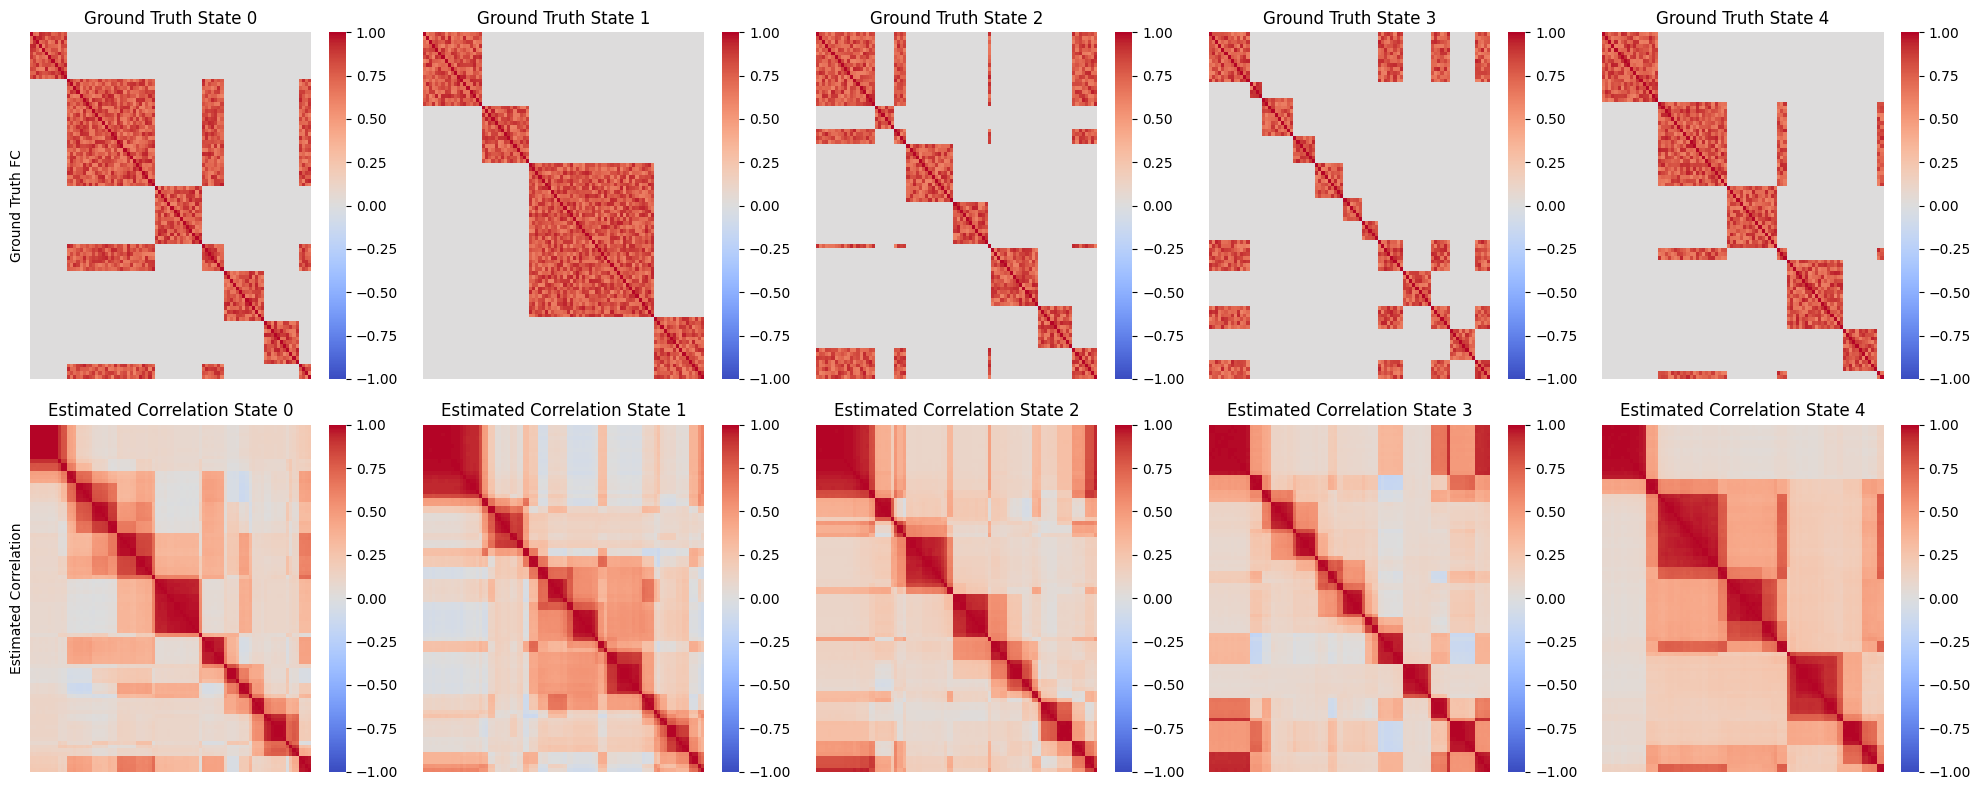

In [52]:
matrices = corr_of_states(data_list, shift=2)

In [53]:
matrices_est = []
for i in range(K):
    matrices_est.append(state_FC[:,:,i])
print(len(matrices_est))
print(len(matrices))
print(matrices_est[0].shape)

5
5
(90, 90)


In [54]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

# Flatten matrices for similarity computation
def flatten_corr(mat):
    return mat[np.triu_indices_from(mat, k=1)]  # Solo parte superior, sin diagonal

# Crear matriz de similitud (por correlación)
n_states = len(matrices)
cost_matrix = np.zeros((n_states, n_states))

for i in range(n_states):
    for j in range(n_states):
        r, _ = pearsonr(flatten_corr(matrices[i]), flatten_corr(matrices_est[j]))
        cost_matrix[i, j] = -r  # Negar para convertir en problema de minimización

# Asignación óptima
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Reordenar estimados
reordered_estimated = [matrices_est[j] for j in col_ind]

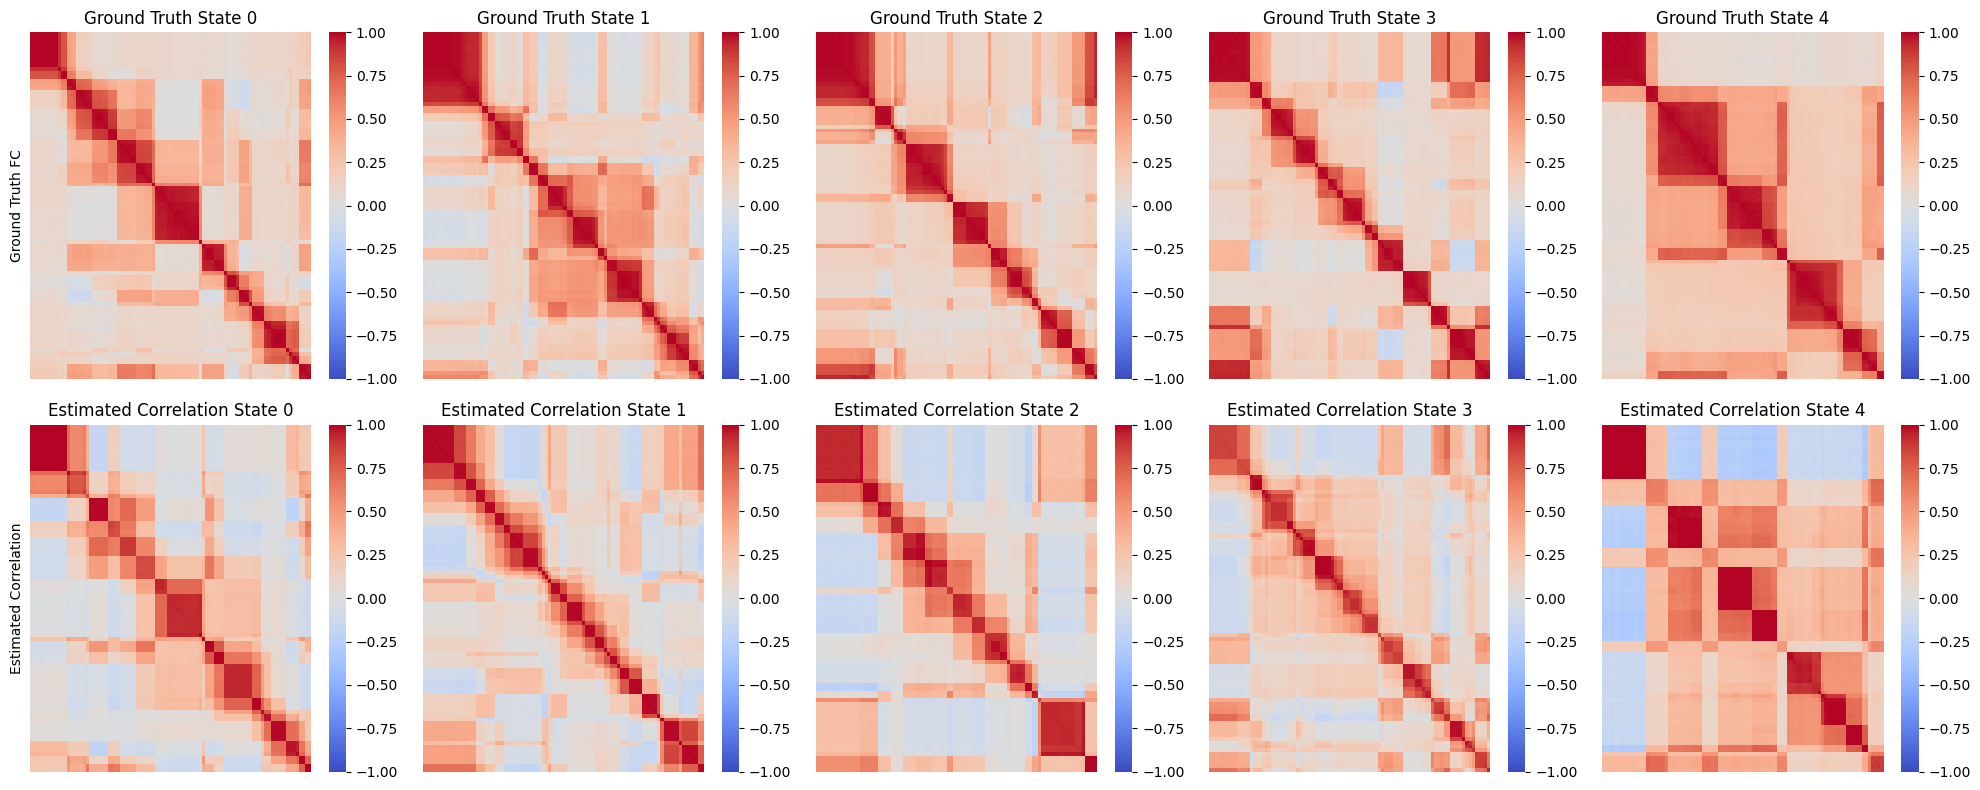

In [55]:
plot_fc_and_corr_matrices(matrices, reordered_estimated, region_labels=None)

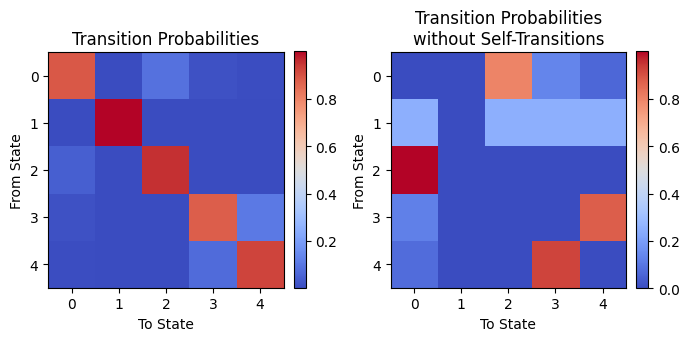

In [56]:
TP = hmm.P.copy() # the transition probability matrix
# Plot Transition Probabilities
plt.figure(figsize=(7, 4))

# Plot 1: Original Transition Probabilities
plt.subplot(1, 2, 1)
plt.imshow(TP, cmap=cmap, interpolation='nearest')  # Improved color mapping
plt.title('Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.colorbar(fraction=0.046, pad=0.04)

# Plot 2: Transition Probabilities without Self-Transitions
TP_noself = TP - np.diag(np.diag(TP))  # Remove self-transitions
TP_noself2 = TP_noself / TP_noself.sum(axis=1, keepdims=True)  # Normalize probabilities
plt.subplot(1, 2, 2)
plt.imshow(TP_noself2, cmap=cmap, interpolation='nearest')  # Improved color mapping
plt.title('Transition Probabilities\nwithout Self-Transitions')
plt.xlabel('To State')
plt.ylabel('From State')
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

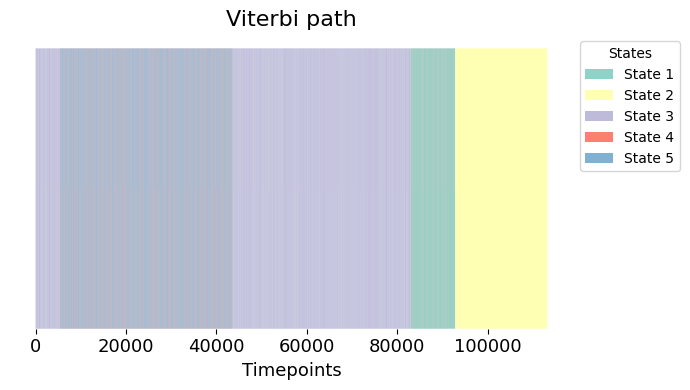

In [57]:
vpath = hmm.decode(X=None, Y=data, indices=index, viterbi=True)
graphics.plot_vpath(vpath, title="Viterbi path")

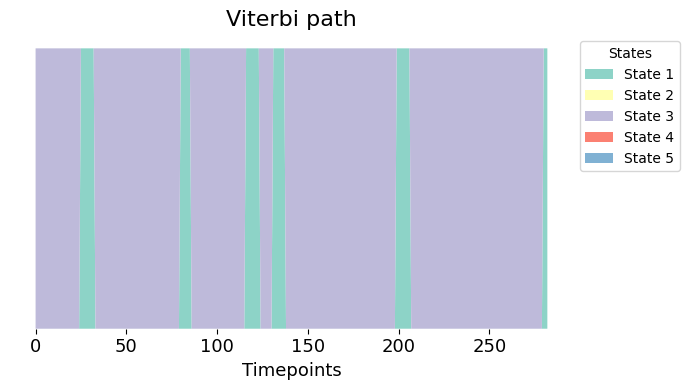

In [58]:
num_subject = 0
graphics.plot_vpath(vpath[index[num_subject,0]:index[num_subject,1],:], title="Viterbi path")

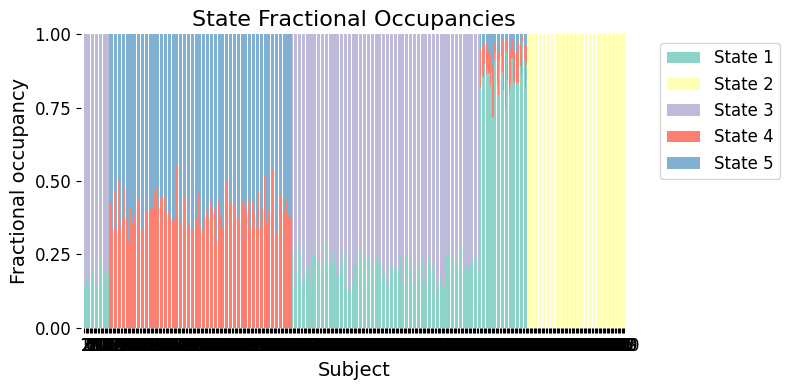

In [59]:
FO = utils.get_FO(Gamma, indices=index)
graphics.plot_FO(FO, num_x_ticks=FO.shape[0])

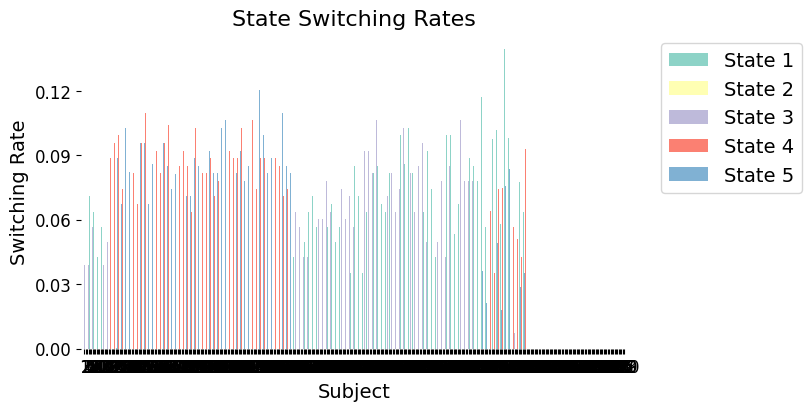

In [60]:
SR = utils.get_switching_rate(Gamma, index)
graphics.plot_switching_rates(SR, num_x_ticks=SR.shape[0])

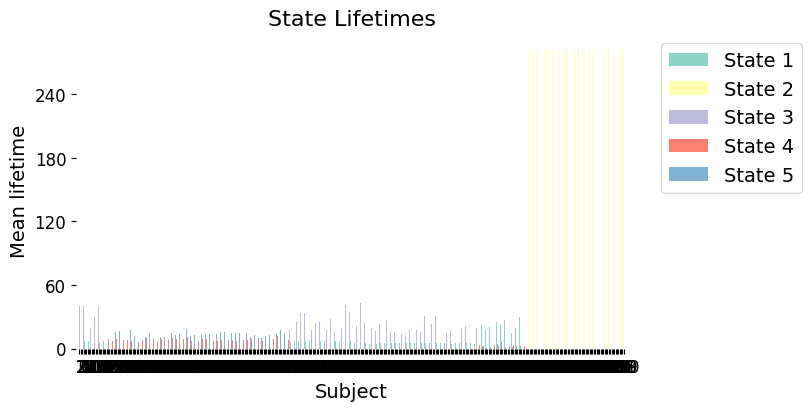

In [61]:
LTmean, LTmed, LTmax = utils.get_life_times(vpath, index)
graphics.plot_state_lifetimes(LTmean, num_x_ticks=LTmean.shape[0], ylabel='Mean lifetime') #LTmean[:10] muestra los 10 primeros sujetos

### Computing the Transition matrix of each subject

In [62]:
import numpy as np

def compute_subject_TP_from_vpaths(vpaths, K, eps=1e-6):
    """
    vpaths : lista de arrays, len = n_subj
             vpaths[s] tiene shape (T_s,), con estados en {0, ..., K-1}
    K      : número de estados del HMM

    Devuelve:
    A_subj : array (n_subj, K, K)
             matriz de transición por sujeto (filas normalizadas)
    """
    n_subj = len(vpaths)
    A_subj = np.zeros((n_subj, K, K), dtype=float)

    for s, path in enumerate(vpaths):
        path = np.asarray(path)
        #
        for t in range(len(path) - 1):
            i = path[t]
            j = path[t + 1]
            A_subj[s, i, j] += 1.0

        # normalizar filas para obtener probabilidades
        #row_sums = A_subj[s].sum(axis=1, keepdims=True)

        row_sums = A_subj[s].sum(axis=1)
        zero_rows = (row_sums == 0)

        # si alguna fila no tuvo salidas, evitar división por cero
        zero_rows = (row_sums == 0)

        if np.any(zero_rows):
            # por ejemplo, fila sin transiciones -> distribución uniforme
            A_subj[s][zero_rows, :] = 1.0 / K
            row_sums = A_subj[s].sum(axis=1, keepdims=True)

        A_subj[s] /= row_sums

    return A_subj


(283,)
400
(400, 7, 7)


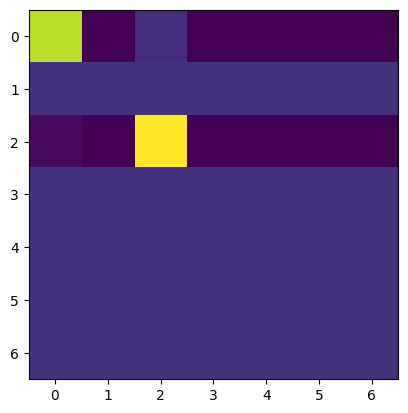

In [63]:
vpaths = [np.argmax(vpath[index[i,0]:index[i,1],:],axis=1) for i in range(n_subjects)]
print(vpaths[0].shape)
print(len(vpaths))

A = compute_subject_TP_from_vpaths(vpaths, K=7)
print(A.shape)  # (n_subj, K, K)

plt.imshow(A[0,:,:])
plt.show()

In [64]:
print(SR[0])

[3.90070922e-02 7.89443282e-31 3.90070922e-02 5.89016231e-51
 2.65010411e-49]


# Embedding

In [65]:
print(f"Transition matrix shape: {A.shape}")
print(f"Fraction occupancy shape: {FO.shape}")
print(f"Switching rate shape: {SR.shape}")
print(f"Dwell times shape: {LTmean.shape}")

Transition matrix shape: (400, 7, 7)
Fraction occupancy shape: (400, 5)
Switching rate shape: (400, 5)
Dwell times shape: (400, 5)


In [66]:
import numpy as np

def build_dynamic_embedding(fo, dwell, switch_rate, A):
    """
    Build dynamic embeddings for each subject.

    Parameters
    fo : array (n_subj, K), Fractional occupancies.
    dwell : array (n_subj, K) mean Dwell times.
    switch_rate : array (n_subj,K) Switching rate per state for subject.
    A : array (n_subj, K, K) Transition matrices for subject

    Returns
    -------
    X_dyn : array (n_subj, dim_embedding)
        dynamic embedding for subject
    """

    n_subj, K = fo.shape
    embeddings = []

    tri_idx = np.triu_indices(K, k=1)  # parte superior sin diagonal

    for s in range(n_subj):
        # 1. Fractional Occupancy
        fo_s = fo[s]                   # (K,)

        # 2. Dwell time por estado
        dwell_s = dwell[s]             # (K,)

        # 3. Switching por estado (ya es vector de longitud K)
        sw_s = switch_rate[s]          # (K,)

        # 4. Matriz de transición vectorizada (upper triangular sin diagonal)
        A_s = A[s]                     # (K, K)
        A_flat = A_s[tri_idx]          # (K*(K-1)/2,)

        # Concatenar todas las features
        feat_s = np.concatenate([fo_s, dwell_s, sw_s, A_flat])
        embeddings.append(feat_s)

    X_dyn = np.vstack(embeddings)
    return X_dyn


In [67]:
X_dyn = build_dynamic_embedding(FO, LTmean, SR, A)
print(X_dyn.shape)  # debería ser (800, 42) si K=7

(400, 25)


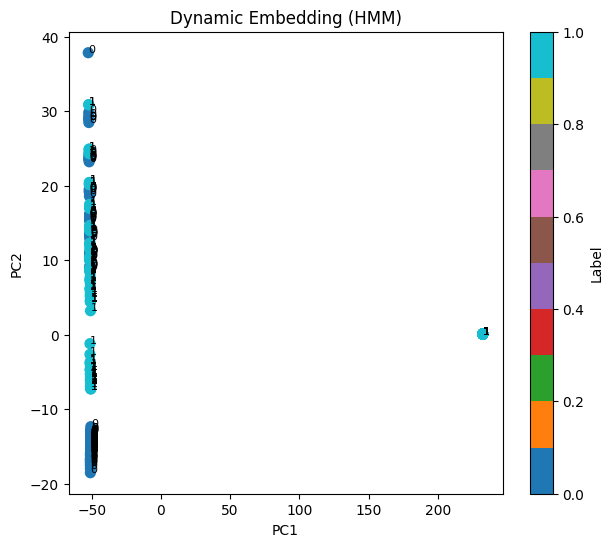

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embedding_with_labels(X, labels, title="Embedding"):
    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10", s=50)

    # agregar labels numéricos
    for i in range(len(labels)):
        plt.text(Z[i,0], Z[i,1], str(labels[i]), fontsize=8)

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(False)
    plt.colorbar(scatter, label="Label")
    plt.show()

# Uso
plot_embedding_with_labels(X_dyn, labels, "Dynamic Embedding (HMM)")


In [69]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# X_dyn = embedding dinámico (n_subj, dim)
# y = etiquetas (n_subj,)

# 1. Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_dyn, labels, test_size=0.2, random_state=42, stratify=labels
)

# 2. Pipeline: estandarizar + regresión logística
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=500,
        class_weight="balanced"   # útil si hay desbalance
    ))
])

# 3. Entrenar
clf.fit(X_train, y_train)

# 4. Predecir
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# 5. Métricas
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", acc)
print("AUC:", auc)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
AUC: 1.0

Confusion Matrix:
 [[40  0]
 [ 0 40]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [70]:
# plot the borders beetween groups in the visualization of PCA
def plot_lr_boundary_on_2d(Z2, y, C=1.0, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))
    clf2d = LogisticRegression(C=C, max_iter=1000)
    clf2d.fit(Z2, y)

    x_min, x_max = Z2[:,0].min()-0.5, Z2[:,0].max()+0.5
    y_min, y_max = Z2[:,1].min()-0.5, Z2[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    proba = clf2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    cf = ax.contourf(xx, yy, proba, levels=np.linspace(0,1,21),
                     cmap="coolwarm", alpha=0.30)
    ax.contour(xx, yy, proba, levels=[0.5], colors='k', linewidths=2)

    return clf2d, cf


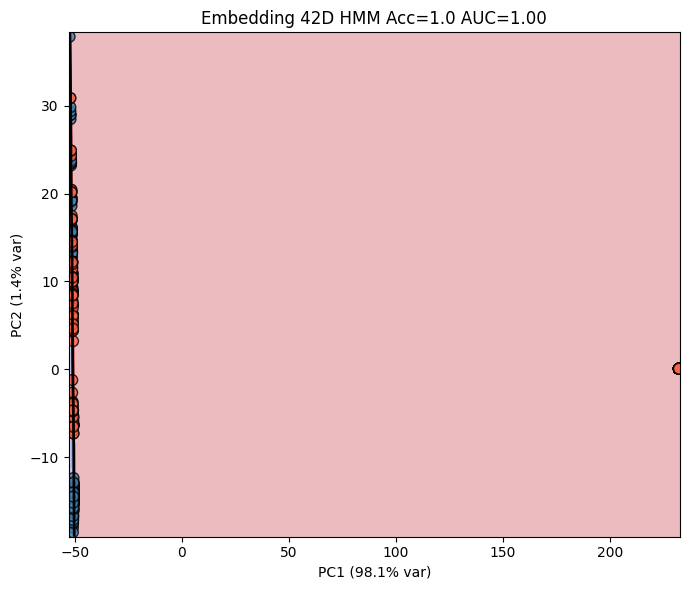

In [71]:
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(X_dyn)

fig, ax = plt.subplots(figsize=(7,6))

clf2d, cf = plot_lr_boundary_on_2d(Z_pca, labels, C=1.0, ax=ax)
colors = ['steelblue' if l==0 else 'tomato' for l in labels]
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=colors, s=60, alpha=0.8, edgecolor='k')

plt.title(f"Embedding {42}D HMM Acc={acc} AUC={auc:.2f}")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
# text_str = (
#               f"n_neighbors = {params['n_neighbors']},  "
#               f"min_dist = {params['min_dist']:.2f},  "
#               f"n_components = {params['n_components']},  "
#               f"metric = {params['metric']}"
#               )

#plt.figtext(0.5, -0.05, text_str, wrap=True, ha="center", fontsize=10, color="dimgray")
plt.tight_layout()
plt.show()